# Usage (quick version)
This is a quick tour of CovsirPhy. Details of datasets and scenario analysis will be explained.

## Preparation
Prepare the packages.

In [1]:
# Standard users
# !pip install covsirphy

In [2]:
# Developers (Note: this notebook is in example directory)
import os
os.chdir("../")

In [3]:
import covsirphy as cs
cs.__version__

'2.12.0-mu.new.359.362.366.367.fix.360.373.solving.357'

## Dataset preparation
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.
Download the datasets to "input" direcotry and load them.

If "input" directory has the datasets, `DataLoader` will load the local files. If the datasets were updated in remote servers, `DataLoader` will update the local files automatically.

In [4]:
data_loader = cs.DataLoader("input")
# The number of cases (JHU style)
jhu_data = data_loader.jhu(verbose=True)
# Population in each country
population_data = data_loader.population(verbose=True)
# Government Response Tracker (OxCGRT)
oxcgrt_data = data_loader.oxcgrt(verbose=True)

Retrieving datasets from COVID-19 Data Hub: https://covid19datahub.io/



Please set verbose=2 to see the detailed citation list.




### The number of cases (JHU style)
The main dataset is that of the number of cases. This includes "Confirmed", "Infected", "Recovered" and "Fatal". "Infected" was calculated as "Confirmed - Recovered - Fatal".

In [5]:
# Description/citation
print(jhu_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [6]:
# Citation of COVID-19 Data Hub: this was shown when `DataLoader.jhu(verbose=True)
# print(data_loader.covid19dh_citation)

In [7]:
# Raw data
jhu_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
350182,2020-11-30,919.0,880,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350183,2020-12-01,923.0,901,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350184,2020-12-02,930.0,902,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350185,2020-12-03,931.0,910,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350186,2020-12-04,931.0,910,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [8]:
# Cleaned data
jhu_data.cleaned().tail()

,Date,Country,Province,Confirmed,Infected,Fatal,Recovered
350182,2020-11-30,Colombia,Vichada,919,27,12,880
350183,2020-12-01,Colombia,Vichada,923,10,12,901
350184,2020-12-02,Colombia,Vichada,930,16,12,902
350185,2020-12-03,Colombia,Vichada,931,9,12,910
350186,2020-12-04,Colombia,Vichada,931,9,12,910


In [9]:
# Subset for a country
jhu_data.subset("Japan", province="Tokyo").tail()

,Date,Confirmed,Infected,Fatal,Recovered
256,2020-11-30,40939,4409,489,36041
257,2020-12-01,41311,4404,494,36413
258,2020-12-02,41811,4432,499,36880
259,2020-12-03,42344,4495,501,37348
260,2020-12-04,42793,4615,509,37669


In [10]:
# Total
total_df = jhu_data.total()
total_df.tail()

,Confirmed,Infected,Fatal,Recovered,Fatal per Confirmed,Recovered per Confirmed,Fatal per (Fatal or Recovered)
Date,,,,,,,
2020-11-30,63345415,21365841,1470842,40508732,0.023219,0.639490,0.035037
2020-12-01,63936955,21487012,1482924,40967019,0.023194,0.640741,0.034933
2020-12-02,64581677,21685516,1494549,41401612,0.023142,0.641074,0.034841
2020-12-03,65243154,21936007,1505911,41801236,0.023082,0.640699,0.034773
2020-12-04,65252355,21943155,1506022,41803178,0.023080,0.640639,0.034774


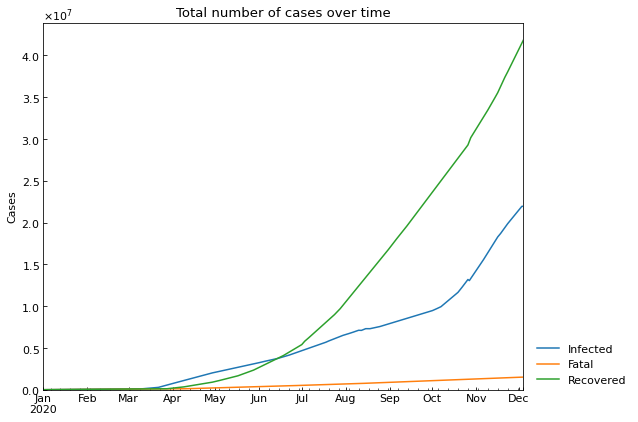

In [11]:
# Plot the total values
cs.line_plot(total_df[["Infected", "Fatal", "Recovered"]], "Total number of cases over time")

### (Optional) Replace the dataset in Japan
If we have dataset for each country, we can use it optionally.

In [12]:
# Registered data in jhu_data
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
295,2020-11-30,148888,23335,2151,123402
296,2020-12-01,150916,23382,2192,125342
297,2020-12-02,153350,23850,2224,127276
298,2020-12-03,155867,24390,2260,129217
299,2020-12-04,158308,24853,2305,131150


In [13]:
# Download the dataset in Japan and show the citation
japan_data = data_loader.japan()
print(japan_data.citation)

Lisphilar (2020), COVID-19 dataset in Japan, GitHub repository, https://github.com/lisphilar/covid19-sir/data/japan


In [14]:
# Replace the dataset for Japan
jhu_data.replace(japan_data)
# Show the new records in Japan
jhu_data.subset("Japan").tail()

,Date,Confirmed,Infected,Fatal,Recovered
293,2020-11-30,146760,21196,2119,123445
294,2020-12-01,148694,21085,2139,125470
295,2020-12-02,150386,20910,2172,127304
296,2020-12-03,152827,21373,2213,129241
297,2020-12-04,155232,21816,2240,131176


### Population in each country
Population values are necessary to calculate the number of susceptible people. Susceptible is a variable of SIR-derived models.

In [15]:
# Description/citation
print(population_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [16]:
# Raw data (the same as jhu_data)
population_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
350182,2020-11-30,919.0,880,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350183,2020-12-01,923.0,901,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350184,2020-12-02,930.0,902,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350185,2020-12-03,931.0,910,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350186,2020-12-04,931.0,910,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [17]:
# Cleaned data
population_data.cleaned().tail()

,ISO3,Country,Province,Date,Population
295264,COL,Colombia,Vichada,2020-11-30,107808
295265,COL,Colombia,Vichada,2020-12-01,107808
295266,COL,Colombia,Vichada,2020-12-02,107808
295267,COL,Colombia,Vichada,2020-12-03,107808
295268,COL,Colombia,Vichada,2020-12-04,107808


In [18]:
population_data.value("Japan", province=None)

126529100

In [19]:
# Register population value of Tokyo in Japan
# https://www.metro.tokyo.lg.jp/tosei/hodohappyo/press/2020/06/11/07.html
population_data.update(14_002_973, "Japan", province="Tokyo")
population_data.value("Japan", province="Tokyo")

14002973

### Government Response Tracker (OxCGRT)
This will be used in [Usage (details: policy measures)](https://lisphilar.github.io/covid19-sir/usage_policy.html).

In [20]:
# Description/citation
print(oxcgrt_data.citation)

(Secondary source) Guidotti, E., Ardia, D., (2020), "COVID-19 Data Hub", Journal of Open Source Software 5(51):2376, doi: 10.21105/joss.02376.


In [21]:
# Raw data (the same as jhu_data)
oxcgrt_data.raw.tail()

,ObservationDate,Confirmed,Recovered,Deaths,Population,ISO3,Province/State,Country/Region,school_closing,workplace_closing,cancel_events,gatherings_restrictions,transport_closing,stay_home_restrictions,internal_movement_restrictions,international_movement_restrictions,information_campaigns,testing_policy,contact_tracing,stringency_index
350182,2020-11-30,919.0,880,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350183,2020-12-01,923.0,901,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350184,2020-12-02,930.0,902,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350185,2020-12-03,931.0,910,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74
350186,2020-12-04,931.0,910,12,107808.0,COL,Vichada,Colombia,3,1,1,3,1,1,1,4,2,2,2,65.74


In [22]:
# Cleaned data
oxcgrt_data.cleaned().tail()

,Date,Country,ISO3,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
350182,2020-11-30,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
350183,2020-12-01,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
350184,2020-12-02,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
350185,2020-12-03,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74
350186,2020-12-04,Colombia,COL,3,1,1,3,1,1,1,4,2,2,2,65.74


In [23]:
# Subset for a country
oxcgrt_data.subset("Japan").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
334,2020-11-30,1,1,1,0,0,1,1,3,2,3,2,40.74
335,2020-12-01,1,1,1,0,0,1,1,3,2,3,2,40.74
336,2020-12-02,1,1,1,0,0,1,1,3,2,3,2,40.74
337,2020-12-03,1,1,1,0,0,1,1,3,2,3,2,40.74
338,2020-12-04,1,1,1,0,0,1,1,3,2,3,2,40.74


In [24]:
# Subset for a country (using ISO3 code)
oxcgrt_data.subset("JPN").tail()

,Date,School_closing,Workplace_closing,Cancel_events,Gatherings_restrictions,Transport_closing,Stay_home_restrictions,Internal_movement_restrictions,International_movement_restrictions,Information_campaigns,Testing_policy,Contact_tracing,Stringency_index
334,2020-11-30,1,1,1,0,0,1,1,3,2,3,2,40.74
335,2020-12-01,1,1,1,0,0,1,1,3,2,3,2,40.74
336,2020-12-02,1,1,1,0,0,1,1,3,2,3,2,40.74
337,2020-12-03,1,1,1,0,0,1,1,3,2,3,2,40.74
338,2020-12-04,1,1,1,0,0,1,1,3,2,3,2,40.74


## Scenario analysis
As an example, we will analysis the number of cases in Japan.

In [25]:
snl = cs.Scenario(jhu_data, population_data, country="Japan", province=None)

### Check records
Let's see the records at first. `Scenario.records()` method return the records as a pandas dataframe and show a line plot.

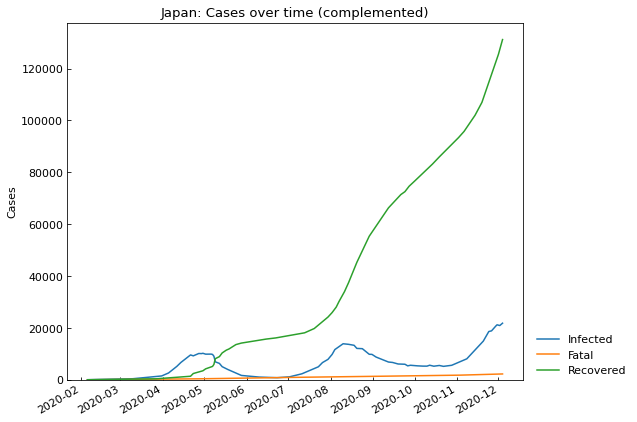

,Date,Confirmed,Infected,Fatal,Recovered
293,2020-11-30,146760,21196,2119,123445
294,2020-12-01,148694,21085,2139,125470
295,2020-12-02,150386,20910,2172,127304
296,2020-12-03,152827,21373,2213,129241
297,2020-12-04,155232,21816,2240,131176


In [26]:
record_df = snl.records()
record_df.tail()

### S-R trend analysis
S-R trend analysis finds the change points of SIR-derived ODE parameters. Details will be explained in [Usage (details: phases)](https://lisphilar.github.io/covid19-sir/usage_phases.html).

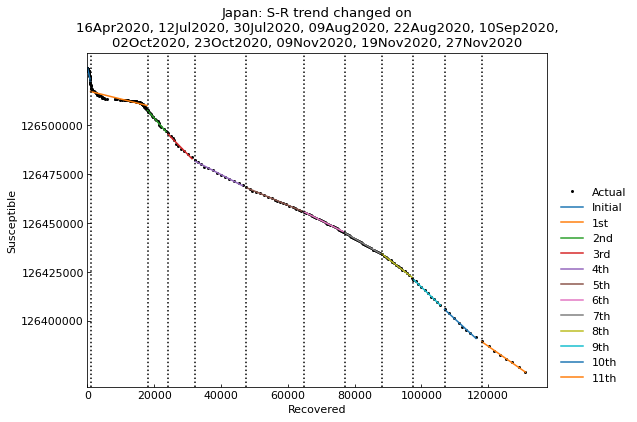

,Type,Start,End,Population
0th,Past,06Feb2020,15Apr2020,126529100
1st,Past,16Apr2020,11Jul2020,126529100
2nd,Past,12Jul2020,29Jul2020,126529100
3rd,Past,30Jul2020,08Aug2020,126529100
4th,Past,09Aug2020,21Aug2020,126529100
5th,Past,22Aug2020,09Sep2020,126529100
6th,Past,10Sep2020,01Oct2020,126529100
7th,Past,02Oct2020,22Oct2020,126529100
8th,Past,23Oct2020,08Nov2020,126529100
9th,Past,09Nov2020,18Nov2020,126529100


In [27]:
# Perform S-R trend analysis and set phases
snl.trend(set_phases=True)
snl.summary()

### Hyperparameter estimation of ODE models
Here, we will estimate the parameter values of SIR-derived models. As an example, we use SIR-F model. Details of models will be explained in [Usage (details: theoritical datasets)](https://lisphilar.github.io/covid19-sir/usage_theoretical.html).

In [28]:
# Estimate the parameter values of SIR-F model
snl.estimate(cs.SIRF)


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	10th phase (22Aug2020 - 09Sep2020): finished  284 trials in 0 min 20 sec


	 1st phase (10Sep2020 - 01Oct2020): finished  888 trials in 1 min  0 sec

	 9th phase (19Nov2020 - 26Nov2020): finished  780 trials in 0 min 50 sec

	 0th phase (30Jul2020 - 08Aug2020): finished 2208 trials in 3 min  1 sec

	 4th phase (06Feb2020 - 15Apr2020): finished 2067 trials in 3 min  1 sec

	 8th phase (23Oct2020 - 08Nov2020): finished 2171 trials in 3 min  1 sec

	 7th phase (09Aug2020 - 21Aug2020): finished 2160 trials in 3 min  1 sec

	 5th phase (27Nov2020 - 04Dec2020): finished  179 trials in 0 min 10 sec

	 3rd phase (12Jul2020 - 29Jul2020): finished 2186 trials in 3 min  0 sec

	 2nd phase (02Oct2020 - 22Oct2020): finished 2161 trials in 3 min  1 sec

	11th phase (16Apr2020 - 11Jul2020): finished 2024 trials in 3 min  1 sec

	 6th phase (09Nov2020 - 18Nov2020): finished 2588 trials in 3 min  0 sec

Completed optimization. Total: 8 min 24 sec


In [29]:
# Show the sumamry of parameter estimation
snl.summary()

,Type,Start,End,Population,ODE,Rt,theta,kappa,rho,sigma,tau,alpha1 [-],1/alpha2 [day],1/gamma [day],1/beta [day],RMSLE,Trials,Runtime
0th,Past,06Feb2020,15Apr2020,126529100,SIR-F,6.39,0.017300,0.000018,0.008511,0.001290,120,0.017,4669,64,9,0.292684,2067,3 min 1 sec
1st,Past,16Apr2020,11Jul2020,126529100,SIR-F,0.52,0.061863,0.000137,0.002599,0.004525,120,0.062,609,18,32,0.335772,2024,3 min 1 sec
2nd,Past,12Jul2020,29Jul2020,126529100,SIR-F,2.03,0.000907,0.000002,0.010703,0.005258,120,0.001,34312,15,7,0.020379,2186,3 min 0 sec
3rd,Past,30Jul2020,08Aug2020,126529100,SIR-F,2.01,0.001246,0.000025,0.011016,0.005457,120,0.001,3335,15,7,0.029780,2208,3 min 1 sec
4th,Past,09Aug2020,21Aug2020,126529100,SIR-F,0.92,0.000055,0.000060,0.006734,0.007295,120,0.000,1388,11,12,0.030359,2160,3 min 1 sec
5th,Past,22Aug2020,09Sep2020,126529100,SIR-F,0.66,0.018628,0.000016,0.005330,0.007891,120,0.019,5246,10,15,0.041022,284,0 min 20 sec
6th,Past,10Sep2020,01Oct2020,126529100,SIR-F,0.89,0.013605,0.000002,0.007090,0.007827,120,0.014,34508,10,11,0.025533,888,1 min 0 sec
7th,Past,02Oct2020,22Oct2020,126529100,SIR-F,0.99,0.000633,0.000072,0.008420,0.008398,120,0.001,1162,9,9,0.013487,2161,3 min 1 sec
8th,Past,23Oct2020,08Nov2020,126529100,SIR-F,1.26,0.000121,0.000104,0.009710,0.007574,120,0.000,799,11,8,0.014846,2171,3 min 1 sec
9th,Past,09Nov2020,18Nov2020,126529100,SIR-F,1.57,0.000764,0.000067,0.011530,0.007293,120,0.001,1236,11,7,0.011931,2588,3 min 0 sec


### Accuracy of estimation

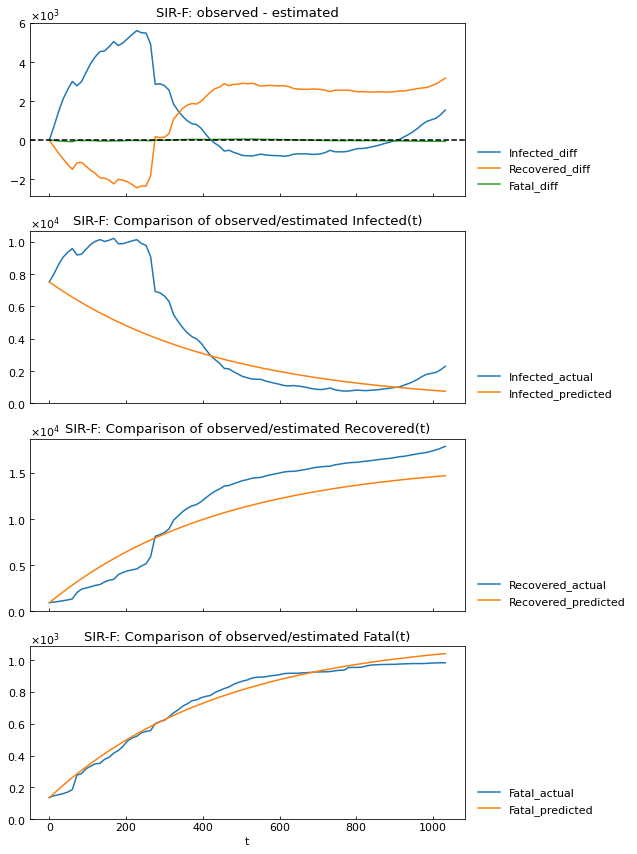

In [30]:
snl.estimate_accuracy(phase="1st")

### Get parameter value

In [31]:
snl.get("Rt", phase="4th")

0.92

### Show parameter history

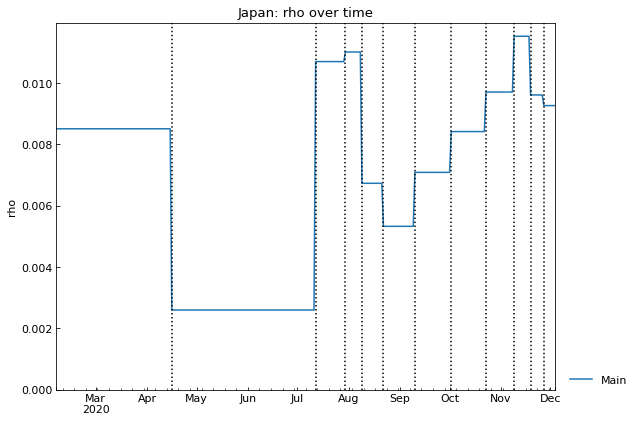

In [32]:
_ = snl.history(target="rho")

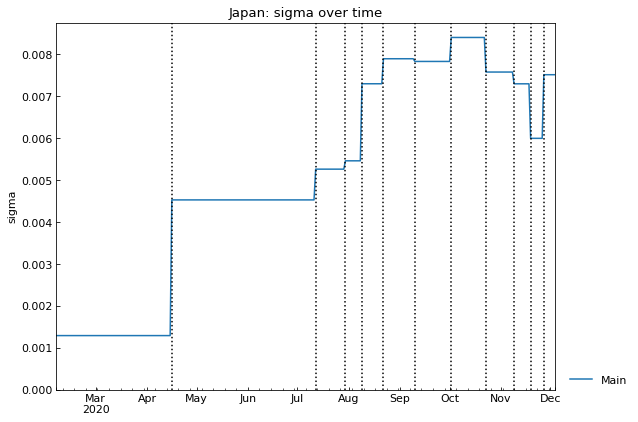

In [33]:
_ = snl.history(target="sigma")

### Show the history of reproduction number

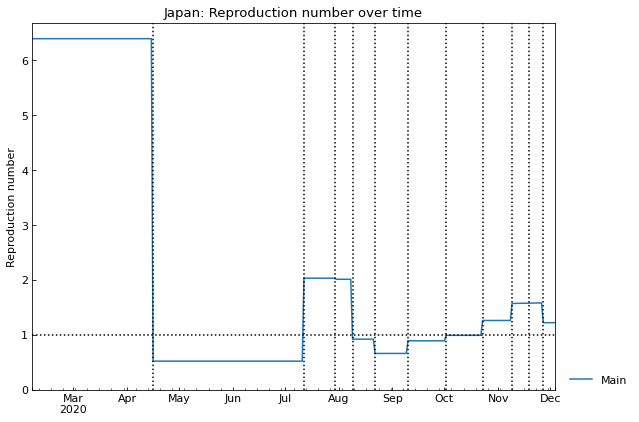

In [34]:
_ = snl.history(target="Rt")

### Simulate the number of cases

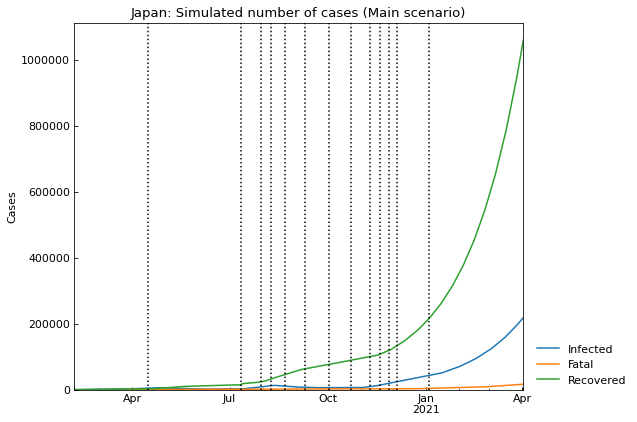

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,1201556,15443,202760,983353
418,2021-03-30,1224105,15729,206574,1001802
419,2021-03-31,1247071,16019,210456,1020596
420,2021-04-01,1270463,16315,214406,1039742
421,2021-04-02,1294288,16617,218425,1059246


In [35]:
snl.clear(name="Main")
snl.add(days=30)
snl.add(end_date="01Apr2021", name="Main")
main_sim_df = snl.simulate(name="Main")
main_sim_df.tail()

### Simulate another scenario
If $\sigma$ will be double in 30 days, how many cases will be?

In [36]:
sigma_current = snl.get("sigma", name="Main", phase="last")
sigma_current

0.007510213466742352

In [37]:
sigma_new = sigma_current * 2
sigma_new

0.015020426933484704

In [38]:
snl.clear(name="Medicine")
snl.add(name="Medicine", days=30, sigma=sigma_current)
snl.add(name="Medicine", end_date="01Apr2021", sigma=sigma_new)
snl.summary()

Type      Start        End  Population    ODE    Rt  \
Scenario Phase                                                          
Main     0th      Past  06Feb2020  15Apr2020   126529100  SIR-F  6.39   
         1st      Past  16Apr2020  11Jul2020   126529100  SIR-F  0.52   
         2nd      Past  12Jul2020  29Jul2020   126529100  SIR-F  2.03   
         3rd      Past  30Jul2020  08Aug2020   126529100  SIR-F  2.01   
         4th      Past  09Aug2020  21Aug2020   126529100  SIR-F  0.92   
         5th      Past  22Aug2020  09Sep2020   126529100  SIR-F  0.66   
         6th      Past  10Sep2020  01Oct2020   126529100  SIR-F  0.89   
         7th      Past  02Oct2020  22Oct2020   126529100  SIR-F  0.99   
         8th      Past  23Oct2020  08Nov2020   126529100  SIR-F  1.26   
         9th      Past  09Nov2020  18Nov2020   126529100  SIR-F  1.57   
         10th     Past  19Nov2020  26Nov2020   126529100  SIR-F  1.58   
         11th     Past  27Nov2020  04Dec2020   126529100  SIR-F  1.22   
         12th   Future  05Dec2020  03Jan2021   126529100  SIR-F  1.22   
         13th   Future  04Jan2021  01Apr2021   126529100  SIR-F  1.22   
Medicine 0th      Past  06Feb2020  15Apr2020   126529100  SIR-F  6.39   
         1st      Past  16Apr2020  11Jul2020   126529100  SIR-F  0.52   
         2nd      Past  12Jul2020  29Jul2020   126529100  SIR-F  2.03   
         3rd      Past  30Jul2020  08Aug2020   126529100  SIR-F  2.01   
         4th      Past  09Aug2020  21Aug2020   126529100  SIR-F  0.92   
         5th      Past  22Aug2020  09Sep2020   126529100  SIR-F  0.66   
         6th      Past  10Sep2020  01Oct2020   126529100  SIR-F  0.89   
         7th      Past  02Oct2020  22Oct2020   126529100  SIR-F  0.99   
         8th      Past  23Oct2020  08Nov2020   126529100  SIR-F  1.26   
         9th      Past  09Nov2020  18Nov2020   126529100  SIR-F  1.57   
         10th     Past  19Nov2020  26Nov2020   126529100  SIR-F  1.58   
         11th     Past  27Nov2020  04Dec2020   126529100  SIR-F  1.22   
         12th   Future  05Dec2020  03Jan2021   126529100  SIR-F  1.22   
         13th   Future  04Jan2021  01Apr2021   126529100  SIR-F  0.61   

                   theta     kappa       rho     sigma  tau  alpha1 [-]  \
Scenario Phase                                                            
Main     0th    0.017300  0.000018  0.008511  0.001290  120       0.017   
         1st    0.061863  0.000137  0.002599  0.004525  120       0.062   
         2nd    0.000907  0.000002  0.010703  0.005258  120       0.001   
         3rd    0.001246  0.000025  0.011016  0.005457  120       0.001   
         4th    0.000055  0.000060  0.006734  0.007295  120       0.000   
         5th    0.018628  0.000016  0.005330  0.007891  120       0.019   
         6th    0.013605  0.000002  0.007090  0.007827  120       0.014   
         7th    0.000633  0.000072  0.008420  0.008398  120       0.001   
         8th    0.000121  0.000104  0.009710  0.007574  120       0.000   
         9th    0.000764  0.000067  0.011530  0.007293  120       0.001   
         10th   0.000347  0.000079  0.009615  0.005993  120       0.000   
         11th   0.002473  0.000093  0.009268  0.007510  120       0.002   
         12th   0.002473  0.000093  0.009268  0.007510  120       0.002   
         13th   0.002473  0.000093  0.009268  0.007510  120       0.002   
Medicine 0th    0.017300  0.000018  0.008511  0.001290  120       0.017   
         1st    0.061863  0.000137  0.002599  0.004525  120       0.062   
         2nd    0.000907  0.000002  0.010703  0.005258  120       0.001   
         3rd    0.001246  0.000025  0.011016  0.005457  120       0.001   
         4th    0.000055  0.000060  0.006734  0.007295  120       0.000   
         5th    0.018628  0.000016  0.005330  0.007891  120       0.019   
         6th    0.013605  0.000002  0.007090  0.007827  120       0.014   
         7th    0.000633  0.000072  0.008420  0.008398  120       0.001   
         8th    0.000121  0

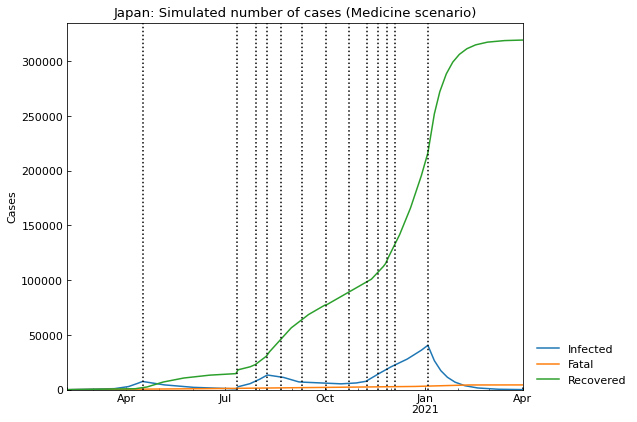

,Date,Confirmed,Fatal,Infected,Recovered
417,2021-03-29,323787,4369,107,319311
418,2021-03-30,323799,4369,100,319330
419,2021-03-31,323809,4369,93,319347
420,2021-04-01,323819,4369,87,319363
421,2021-04-02,323829,4369,81,319379


In [39]:
snl.simulate(name="Medicine").tail()

### Compare the scenarios
We will compare the scenarios with representative values, reproduction number and parameter values.

In [40]:
snl.describe()

,max(Infected),argmax(Infected),Confirmed on 02Apr2021,Infected on 02Apr2021,Fatal on 02Apr2021,13th_Rt
Main,218425,02Apr2021,1294288,218425,16617,1.22
Medicine,40545,04Jan2021,323829,81,4369,0.61


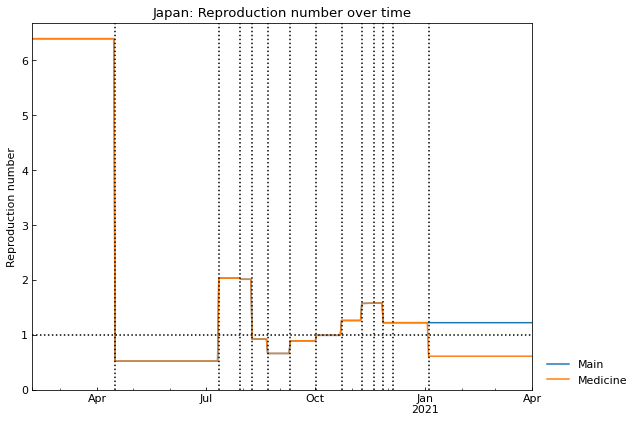

In [41]:
_ = snl.history(target="Rt")

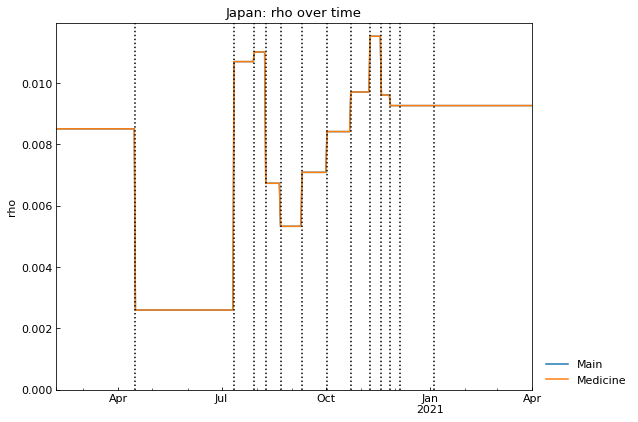

In [42]:
_ = snl.history(target="rho")

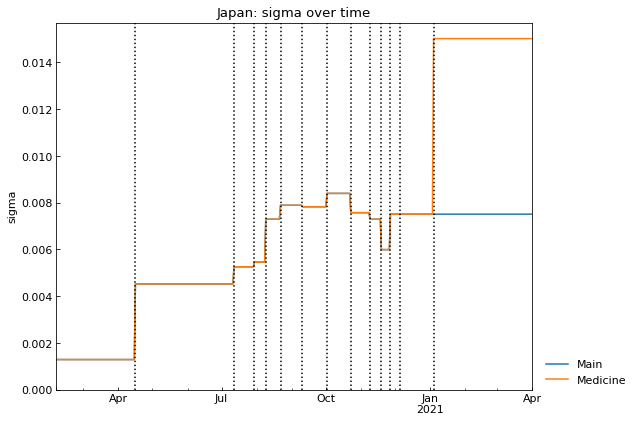

In [43]:
_ = snl.history(target="sigma")

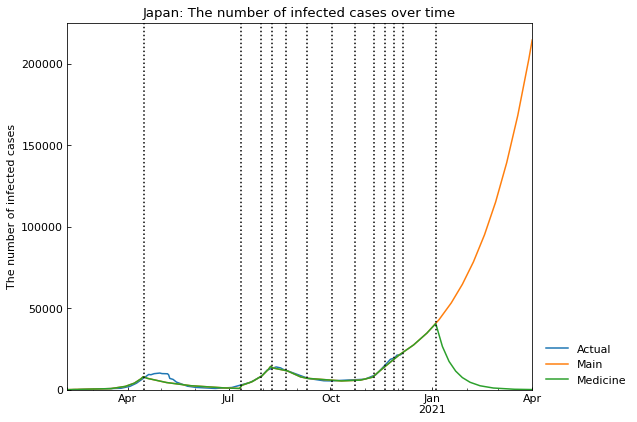

In [44]:
_ = snl.history(target="Infected")

### Change rate of parameters in main scenario
History of each parameter will be shown. Values will be divided by the values in 0th phase.

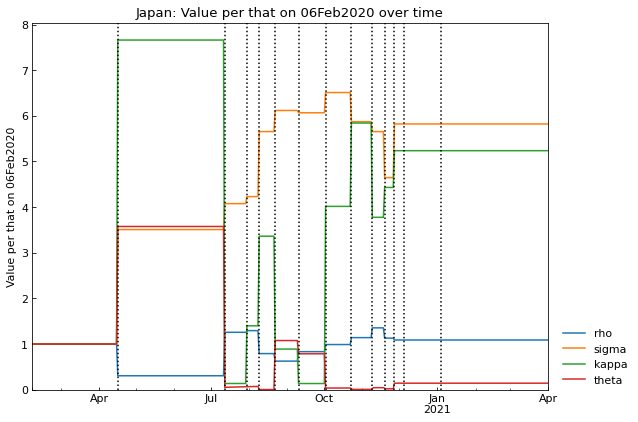

In [45]:
_ = snl.history_rate(name="Main")

## Retrospective analysis
We can evaluate the impact of measures using past records. How many people were infected if the parameter values have not changed sinse 01Sep2020?

In [46]:
# Perform retrospective analysis
snl_retro = cs.Scenario(jhu_data, population_data, "Japan")
snl_retro.retrospective("01Sep2020", model=cs.SIRF, control="Main", target="Retrospective")


<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	10th phase (16Apr2020 - 11Jul2020): finished 2004 trials in 3 min 18 sec


	 8th phase (23Oct2020 - 08Nov2020): finished  210 trials in 0 min 10 sec

	 9th phase (19Nov2020 - 26Nov2020): finished  371 trials in 0 min 20 sec

	 1st phase (10Sep2020 - 01Oct2020): finished 1659 trials in 2 min 21 sec

	 0th phase (30Jul2020 - 08Aug2020): finished 1993 trials in 3 min  1 sec

	 4th phase (06Feb2020 - 15Apr2020): finished 1927 trials in 3 min  1 sec

	11th phase (27Nov2020 - 04Dec2020): finished  526 trials in 0 min 30 sec

	 7th phase (09Aug2020 - 21Aug2020): finished 1954 trials in 3 min  1 sec

	 5th phase (01Sep2020 - 09Sep2020): finished  365 trials in 0 min 20 sec

	12th phase (09Nov2020 - 18Nov2020): finished  519 trials in 0 min 30 sec

	 6th phase (22Aug2020 - 31Aug2020): finished  520 trials in 0 min 30 sec

	 3rd phase (12Jul2020 - 29Jul2020): finished 2421 trials in 3 min  0 sec

	 2nd phase (02Oct2020 - 22Oct2020): finished 2707 trials in 3 min  1 sec

Completed optimization. Total: 9 min 22 sec



<SIR-F model: parameter estimation>
Running optimization with 4 CPUs...


	 5th phase (01Sep2020 - 04Dec2020): finished 7385 trials in 3 min  0 sec

Completed optimization. Total: 3 min  1 sec


In [47]:
# Show the summary of estimation
cols = ["Start", "End", "ODE", "Rt", *cs.SIRF.PARAMETERS] + ["RMSLE", "Trials", "Runtime"]
snl_retro.summary(columns=cols)

Start        End    ODE    Rt     theta     kappa  \
Scenario      Phase                                                          
Main          0th    06Feb2020  15Apr2020  SIR-F  4.68  0.018129  0.000209   
              1st    16Apr2020  11Jul2020  SIR-F  0.58  0.065619  0.000230   
              2nd    12Jul2020  29Jul2020  SIR-F  2.01  0.000054  0.000060   
              3rd    30Jul2020  08Aug2020  SIR-F  1.95  0.000343  0.000079   
              4th    09Aug2020  21Aug2020  SIR-F  0.96  0.000086  0.000144   
              5th    22Aug2020  31Aug2020  SIR-F  0.79  0.000121  0.000294   
              6th    01Sep2020  09Sep2020  SIR-F  0.70  0.000659  0.000284   
              7th    10Sep2020  01Oct2020  SIR-F  0.87  0.000504  0.000344   
              8th    02Oct2020  22Oct2020  SIR-F  0.99  0.000586  0.000242   
              9th    23Oct2020  08Nov2020  SIR-F  1.34  0.005823  0.000180   
              10th   09Nov2020  18Nov2020  SIR-F  1.54  0.000612  0.000263   
              11th   19Nov2020  26Nov2020  SIR-F  1.54  0.000066  0.000152   
              12th   27Nov2020  04Dec2020  SIR-F  1.21  0.000121  0.000294   
Retrospective 0th    06Feb2020  15Apr2020  SIR-F  4.68  0.018129  0.000209   
              1st    16Apr2020  11Jul2020  SIR-F  0.58  0.065619  0.000230   
              2nd    12Jul2020  29Jul2020  SIR-F  2.01  0.000054  0.000060   
              3rd    30Jul2020  08Aug2020  SIR-F  1.95  0.000343  0.000079   
              4th    09Aug2020  21Aug2020  SIR-F  0.96  0.000086  0.000144   
              5th    22Aug2020  31Aug2020  SIR-F  0.79  0.000121  0.000294   
              6th    01Sep2020  04Dec2020  SIR-F  0.79  0.000121  0.000294   

                          rho     sigma     RMSLE  Trials       Runtime  
Scenario      Phase                                                      
Main          0th    0.025774  0.005204  0.250528    1927  3 min  1 sec  
              1st    0.009872  0.015686  0.339072    2004  3 min 18 sec  
              2nd    0.032714  0.016215  0.019275    2421  3 min  0 sec  
              3rd    0.033091  0.016870  0.029122    1993  3 min  1 sec  
              4th    0.020137  0.020836  0.026505    1954  3 min  1 sec  
              5th    0.019179  0.024092  0.016627     520  0 min 30 sec  
              6th    0.016896  0.023823  0.009608     365  0 min 20 sec  
              7th    0.020911  0.023578  0.017988    1659  2 min 21 sec  
              8th    0.026265  0.026285  0.013571    2707  3 min  1 sec  
              9th    0.028655  0.021143  0.029931     210  0 min 10 sec  
              10th   0.033261  0.021348  0.016046     519  0 min 30 sec  
              11th   0.030565  0.019651  0.026365     371  0 min 20 sec  
              12th   0.026814  0.021823  0.011297     526  0 min 30 sec  
Retrospective 0th    0.025774  0.005204  0.250528    1927  3 min  1 sec  
              1st    0.009872  0.015686  0.339072    2004  3 min 18 sec  
              2nd    0.032714  0.016215  0.019275    2421  3 min  0 sec  
              3rd    0.033091  0.016870  0.029122    1993  3 min  1 sec  
              4th    0.020137  0.020836  0.026505    1954  3 min  1 sec  
              5th    0.019179  0.024092  0.016627     520  0 min 30 sec  
              6th    0.019179  0.024092  0.719592    7385  3 min  0 sec

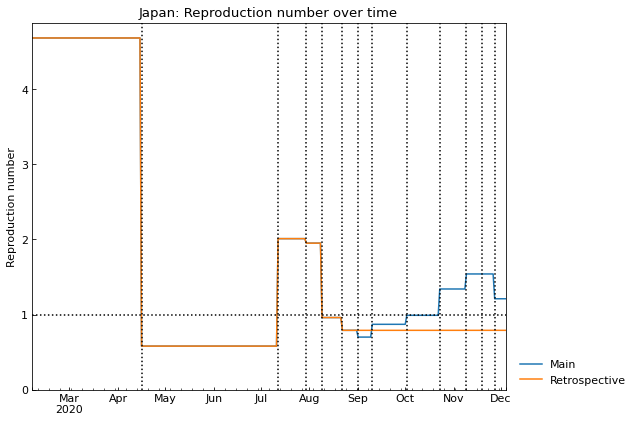

In [48]:
# History of reproduction number
_ = snl_retro.history("Rt")

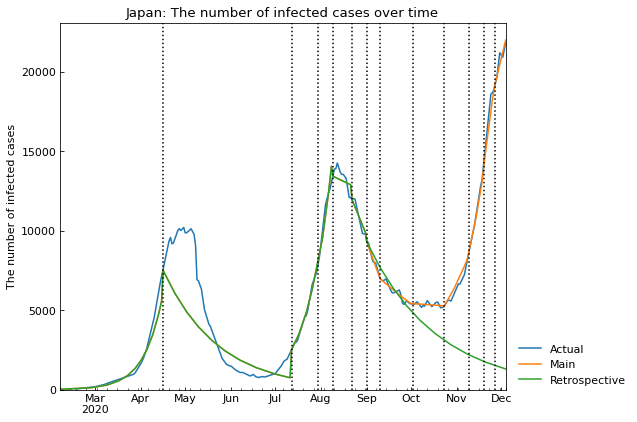

In [49]:
# History of Infected
_ = snl_retro.history("Infected")

In [50]:
# Show the representative values
snl_retro.describe()

,max(Infected),argmax(Infected),Confirmed on 05Dec2020,Infected on 05Dec2020,Fatal on 05Dec2020,6th_Rt,7th_Rt,8th_Rt,9th_Rt,10th_Rt,11th_Rt,12th_Rt
Main,22411,05Dec2020,157334,22411,2249,0.70,0.87,0.99,1.34,1.54,1.54,1.21
Retrospective,14053,08Aug2020,97744,1277,1749,0.79,-,-,-,-,-,-
